# RMSprop behavior in training deep chains
We consider the loss $L(w_1,w_2,\cdots ,w_L) = (1-w_1w_2 \cdots w_L)^2$, and show that RMSprop converges faster than SGD because it adapts to curvature.

In [919]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
import random
%config InlineBackend.figure_format = 'svg'
torch.set_default_tensor_type('torch.DoubleTensor')
sns.set_theme()

### Loss and initialization

In [920]:
### Loss and problem dimension ###
def CHAINloss(x):
    f = (1-torch.prod(x))**2
    return f
loss = CHAINloss
d = 10 #depth
### 

### Hyperparameters ###
eta_SGD1 = 1
eta_SGD2 = 0.1
eta_SGD3 = 0.01
eta_RMS = 0.01
noise = 0.1

### Initialization ###
pert = torch.ones(d)
for i in range(pert.shape[0]):
    if (i%2==0): pert[i] = 1#2*torch.rand(1)-1
tau = 0.2
x0 = 2*tau*torch.rand(d)-tau 
#x0 = torch.zeros(d)+0.1*pert 
steps=int(10000)

### Training

In [921]:
### Training routines ###
def add_perturbation(x,eta):
    with torch.no_grad():
        #modify perturbation size below
        x +=noise*eta*torch.normal(0, 1, size=(x.shape[0],))
        
def compute_hessian(loss, x):
    grad_dict = torch.autograd.grad(loss(x), x, create_graph=True,allow_unused=True)
    grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
    H = torch.ones((grad_vec.size(0), grad_vec.size(0)))
    for i, grad in enumerate(grad_vec):
        H_i_dict = torch.autograd.grad(grad, x, retain_graph=True,allow_unused=True)
        H_i_vec = torch.cat([g.contiguous().view(-1) for g in H_i_dict])
        H[:, i] = H_i_vec
    return H        

def train(x, optimizer, steps, do_hessian):
    losses = torch.zeros(steps)
    lips = torch.zeros(steps)
    grads = torch.zeros([x.shape[0], steps])
    x_history = torch.zeros([x.shape[0], steps])
    for k in range(steps):
        x_history[:,k] = x
        optimizer.zero_grad()
        l = loss(x)
        l.backward()
        optimizer.step()
        losses[k] = l.item()
        grads[:,k] = x.grad
        if (do_hessian==1):
            lips[k] = torch.max(torch.abs(torch.eig(compute_hessian(loss, x), eigenvectors=False)[0]))
        add_perturbation(x,optimizer.param_groups[0]['lr'])
        optimizer.zero_grad()        
    return x_history,losses,grads,lips


### Running optimizers ###
xRMS = x0.clone().detach().requires_grad_(True)
optimizer_RMS = torch.optim.RMSprop([xRMS], lr=eta_RMS, alpha=0.99, eps=1e-08)
x_RMS,losses_RMS,grads_RMS,lips_RMS = train(xRMS, optimizer_RMS,steps,1)

xGD1 = x0.clone().detach().requires_grad_(True)
optimizer_GD1 = torch.optim.SGD([xGD1], lr=eta_SGD1)
x_GD1,losses_GD1,grads_GD1,lips_GD1 = train(xGD1, optimizer_GD1,steps,0)

xGD2 = x0.clone().detach().requires_grad_(True)
optimizer_GD2 = torch.optim.SGD([xGD2], lr=eta_SGD2)
x_GD2,losses_GD2,grads_GD2,lips_GD2 = train(xGD2, optimizer_GD2,steps,0)

xGD3 = x0.clone().detach().requires_grad_(True)
optimizer_GD3 = torch.optim.SGD([xGD3], lr=eta_SGD3)
x_GD3,losses_GD3,grads_GD3,lips_GD3 = train(xGD3, optimizer_GD3,steps,0)

### Postprocessing of training curves

In [922]:
### Moving average filter to smooth curves and compute equivalent stepsize for RMSprop ###
def EMA(g, beta):
    steps = g.shape[1]
    v = torch.zeros(g.shape)
    v[:,0] = g[:,0]
    for k in range(1,steps):
        v[:,k] = beta*v[:,k-1] + (1-beta)*g[:,k-1]
    return v
    

### Gradient Norms ###
grad_norms_RMS=torch.norm(grads_RMS,dim = 0)
grad_norms_GD1=torch.norm(grads_GD1,dim = 0)
grad_norms_GD2=torch.norm(grads_GD2,dim = 0)
grad_norms_GD3=torch.norm(grads_GD3,dim = 0)

### Effective Stepsizes ###
effective_step_RMS = eta_RMS/torch.sqrt(EMA(grads_RMS**2,0.99))
effective_step_GD1 = eta_SGD1+0*effective_step_RMS
effective_step_GD2 = eta_SGD2+0*effective_step_RMS
effective_step_GD3 = eta_SGD3+0*effective_step_RMS

### Smoothing al curves ###
smoothing_param = 0.95

#smoothing the gradient norm
grad_norms_RMS = EMA(grad_norms_RMS.reshape(1,steps),smoothing_param)
grad_norms_GD1 = EMA(grad_norms_GD1.reshape(1,steps),smoothing_param)
grad_norms_GD2 = EMA(grad_norms_GD2.reshape(1,steps),smoothing_param)
grad_norms_GD3 = EMA(grad_norms_GD3.reshape(1,steps),smoothing_param)

#smoothing the loss
losses_RMS = EMA(losses_RMS.reshape(1,steps),smoothing_param)
losses_GD1 = EMA(losses_GD1.reshape(1,steps),smoothing_param)
losses_GD2 = EMA(losses_GD2.reshape(1,steps),smoothing_param)
losses_GD3 = EMA(losses_GD3.reshape(1,steps),smoothing_param)

### Plot (no landscape, for appendix)

/Users/orvi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/orvi/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


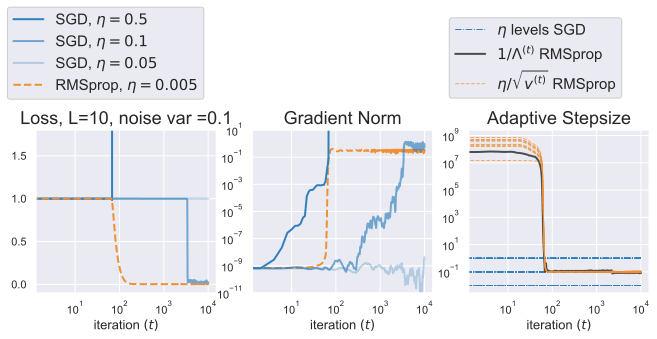

In [923]:
sampling_every = 2

fig= plt.figure(figsize=(11,3))
fig.tight_layout(pad=3.0)
blue = [0.192,0.502,0.741]
blue2 = [0.494,0.647,0.804]
blue3 = [0.712,0.798,0.89]
orange = [0.938,0.566,0.208]
magenta = [0.694,0.259,1.0]

axs = []

### Loss ###
axs1=fig.add_subplot(131)
axs1.semilogx(range(steps)[::sampling_every],losses_GD1.squeeze()[::sampling_every],ls='-',label="SGD, $\eta = 0.5$", linewidth=2,color=blue,alpha=1)
axs1.semilogx(range(steps)[::sampling_every],losses_GD2.squeeze()[::sampling_every],ls='-',label="SGD, $\eta = 0.1$", linewidth=2,color=blue,alpha=0.65)
axs1.semilogx(range(steps)[::sampling_every],losses_GD3.squeeze()[::sampling_every],ls='-',label="SGD, $\eta = 0.05$", linewidth=2,color=blue,alpha=0.3)
axs1.semilogx(range(steps)[::sampling_every],losses_RMS.squeeze()[::sampling_every],ls='--',label="RMSprop, $\eta = 0.005$", linewidth=2,color=orange)
axs1.grid(True)
axs1.set_ylim([-0.1,1.8])
axs1.set_title('Loss, L='+str(d)+', noise var ='+str(noise),size=18)
axs1.legend(fontsize=15,fancybox=True, framealpha=1,loc='upper left',bbox_to_anchor=(-0.2, 1.8))
axs1.set_xlabel('iteration $(t)$',fontsize=13)


### Gradient Norm ###
axs2=fig.add_subplot(132)
axs2.loglog(range(steps)[::sampling_every],grad_norms_RMS.squeeze()[::sampling_every],ls='--', linewidth=2,color=orange)
axs2.loglog(range(steps)[::sampling_every],grad_norms_GD1.squeeze()[::sampling_every],ls='-', linewidth=2,color=blue,alpha=1)
axs2.loglog(range(steps)[::sampling_every],grad_norms_GD2.squeeze()[::sampling_every],ls='-', linewidth=2,color=blue,alpha=0.65)
axs2.loglog(range(steps)[::sampling_every],grad_norms_GD3.squeeze()[::sampling_every],ls='-', linewidth=2,color=blue,alpha=0.3)
axs2.grid(True)
axs2.set_title('Gradient Norm',size=18)
axs2.set_ylim([1e-11,1e1])
axs2.set_xlabel('iteration $(t)$',fontsize=13)
#axs[0,1].yaxis.tick_right()
#fig.savefig('RMS_chain_d10.png', format='png', dpi=200)


### Curvature ###
axs3=fig.add_subplot(133)
lineSGD=axs3.loglog(range(steps)[::sampling_every],effective_step_GD1[:,::sampling_every].T,ls='-.',label="$\eta$ levels SGD", linewidth=1,color=blue)
plt.setp(lineSGD[1:], label="_")
axs3.loglog(range(steps)[::sampling_every],effective_step_GD2[:,::sampling_every].T,ls='-.', linewidth=1,color=blue)
axs3.loglog(range(steps)[::sampling_every],effective_step_GD3[:,::sampling_every].T,ls='-.', linewidth=1,color=blue)
axs3.loglog(range(steps)[::sampling_every],2/lips_RMS[::sampling_every],label="$1/\Lambda^{(t)}$ RMSprop", linewidth=2,color=[0.3,0.3,0.3])
lineRMS=axs3.loglog(range(steps)[::sampling_every],effective_step_RMS[:,::sampling_every].T,ls='--',label="$\eta/\sqrt{v^{(t)}}$ RMSprop", linewidth=1,color=orange,alpha=0.7)
plt.setp(lineRMS[1:], label="_")
axs3.grid(True)
axs3.set_xlabel('iteration $(t)$',fontsize=13)
axs3.legend(fontsize=15,fancybox=True, framealpha=1,bbox_to_anchor=(-0.15, 1.15))
axs3.set_title('Adaptive Stepsize', size=18)

fig.savefig('big_tau_real_RMS_chain_d_'+str(d)+'_noise_'+str(noise)+'_run_2.png', format='png', dpi=200,bbox_inches='tight')

### Plotting loss and gradient and landscape
Note: this needs some tuning because the dynamics is noisy and is therefore not clear to which minima the algorithms will converge to. In particular, one might have to change seed for correct visualization. Alternatively, one can select different RMSprop coordinates to show (indicated as <-- TUNE HERE).

In [924]:
if 0:
    sampling_every = 2

    fig= plt.figure(figsize=(12,9))
    fig.tight_layout(pad=3.0)
    blue = [0.192,0.502,0.741]
    blue2 = [0.494,0.647,0.804]
    blue3 = [0.712,0.798,0.89]
    orange = [0.938,0.566,0.208]
    magenta = [0.694,0.259,1.0]

    axs=[1,2,3,4]

    ### Loss ###
    axs[0]=fig.add_subplot(221)
    axs[0].semilogx(range(steps)[::sampling_every],losses_GD1.squeeze()[::sampling_every],ls='-',label="SGD, $\eta = 1$", linewidth=2,color=blue,alpha=1)
    axs[0].semilogx(range(steps)[::sampling_every],losses_GD2.squeeze()[::sampling_every],ls='-',label="SGD, $\eta = 0.1$", linewidth=2,color=blue,alpha=0.65)
    axs[0].semilogx(range(steps)[::sampling_every],losses_GD3.squeeze()[::sampling_every],ls='-',label="SGD, $\eta = 0.01$", linewidth=2,color=blue,alpha=0.3)
    axs[0].semilogx(range(steps)[::sampling_every],losses_RMS.squeeze()[::sampling_every],ls='--',label="RMSprop, $\eta = 0.01$", linewidth=2,color=orange)
    axs[0].grid(True)
    axs[0].set_ylim([-0.1,1.8])
    axs[0].set_title('Loss',size=17)
    axs[0].legend(fontsize=14,fancybox=True, framealpha=1,loc=1)
    axs[0].set_xlabel('iteration $(t)$',fontsize=13)


    ### Gradient Norm ###
    axs[1]=fig.add_subplot(222)
    axs[1].loglog(range(steps)[::sampling_every],grad_norms_RMS.squeeze()[::sampling_every],ls='--', linewidth=2,color=orange)
    axs[1].loglog(range(steps)[::sampling_every],grad_norms_GD1.squeeze()[::sampling_every],ls='-', linewidth=2,color=blue,alpha=1)
    axs[1].loglog(range(steps)[::sampling_every],grad_norms_GD2.squeeze()[::sampling_every],ls='-', linewidth=2,color=blue,alpha=0.65)
    axs[1].loglog(range(steps)[::sampling_every],grad_norms_GD3.squeeze()[::sampling_every],ls='-', linewidth=2,color=blue,alpha=0.3)
    axs[1].grid(True)
    axs[1].set_title('Gradient Norm',size=17)
    axs[1].set_ylim([1e-11,1e2])
    axs[1].set_xlabel('iteration $(t)$',fontsize=13)
    #axs[0,1].yaxis.tick_right()
    #fig.savefig('RMS_chain_d10.png', format='png', dpi=200)


    ### Curvature ###
    axs[2]=fig.add_subplot(224)
    lineSGD=axs[2].loglog(range(steps)[::sampling_every],effective_step_GD1[:,::sampling_every].T,ls='-.',label="$\eta$ levels SGD", linewidth=1,color=blue)
    plt.setp(lineSGD[1:], label="_")
    axs[2].loglog(range(steps)[::sampling_every],effective_step_GD2[:,::sampling_every].T,ls='-.', linewidth=1,color=blue)
    axs[2].loglog(range(steps)[::sampling_every],effective_step_GD3[:,::sampling_every].T,ls='-.', linewidth=1,color=blue)
    axs[2].loglog(range(steps)[::sampling_every],2/lips_RMS[::sampling_every],label="$1/\Lambda^{(t)}$ RMSprop", linewidth=2,color=[0.3,0.3,0.3])
    lineRMS=axs[2].loglog(range(steps)[::sampling_every],effective_step_RMS[:,::sampling_every].T,ls='--',label="$\eta/\sqrt{v^{(t)}}$ RMSprop", linewidth=1,color=orange,alpha=0.7)
    plt.setp(lineRMS[1:], label="_")
    axs[2].grid(True)
    axs[2].set_xlabel('iteration $(t)$',fontsize=13)
    #axs[1,1].yaxis.tick_right()
    axs[2].legend(fontsize=14,fancybox=True, framealpha=1)
    axs[2].set_title('Adaptive Stepsizes', size=17)


    ### Dynamics
    #Reducing Dynamics to first 2 dimensions
    x_GD = x_GD2[[0,1],0:100]
    x_RMSS = -x_RMS[[1,2],0:100] # <-- TUNE HERE
    gray = '#7D7D7D'
    gold ='#AA9128'
    #plotting landscape
    c0_max=np.max([np.max(x_GD[0,:].detach().numpy()),np.max(x_RMSS[0,:].detach().numpy())])+0.1
    c0_min=np.min([np.min(x_GD[0,:].detach().numpy()),np.min(x_RMSS[0,:].detach().numpy())])-0.1
    c1_max=np.max([np.max(x_GD[1,:].detach().numpy()),np.max(x_RMSS[1,:].detach().numpy())])+0.1
    c1_min=np.min([np.min(x_GD[1,:].detach().numpy()),np.min(x_RMSS[1,:].detach().numpy())])-0.1
    c0_max = np.max([c0_max, 0.5])
    c1_max = np.max([c1_max, 0.5])
    c0_min = np.min([c0_min, -1.5])
    c1_min = np.min([c1_min, -1.5])
    x_interval = torch.arange(c0_min, c0_max, 0.01)
    y_interval = torch.arange(c1_min, c1_max, 0.01) 
    X, Y = torch.meshgrid(x_interval,y_interval)
    Z = X.detach().clone()
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i,j] = loss(torch.tensor([X[i,j],Y[i,j]],requires_grad=False))
    with sns.axes_style("white"):
        axs[3]=fig.add_subplot(223)
        axs[3].contour(X, Y, Z.detach().numpy(),colors=gray,linestyles='-')
        #plotting dynamics
        axs[3].plot(x_GD[0,:].detach().numpy(),x_GD[1,:].detach().numpy(),'-o',color=blue,label="SGD, $\eta = 0.1$",linewidth=2,markersize=6,markevery=5)
        axs[3].plot(x_RMSS[0,:].detach().numpy(),x_RMSS[1,:].detach().numpy(),'-d',color=orange,label="RMSprop, $\eta = 0.01$",linewidth=2,markersize=6,markevery=5)
        axs[3].plot(torch.arange(c0_min, -0.1, 0.1), torch.arange(c0_min, -0.1, 0.1).pow(-1),'-*',label="solution",linewidth=2,color=gold,markersize=9)
        axs[3].plot(0,0,'x',linewidth=3,color=gray,markersize=9)
        axs[3].set_ylim([c1_min, c1_max])
        axs[3].set_aspect('equal')
        axs[3].set_xlabel('$w_1$',fontsize=13)
        axs[3].set_ylabel('$w_2$',fontsize=13)
        axs[3].set_title('Landscape', size=17)
        axs[3].legend(fontsize=10,fancybox=True, framealpha=1)
    fig.tight_layout()
    fig.savefig('RMS_chain_10.png', format='png', dpi=300)
